<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Midterm prep</div>
<div style="text-align: right">Dino Konstantopoulos, 24 February 2020</div>

# Generating random numbers with arbitrary distribution

<br />
<center>
<img src="https://media3.giphy.com/media/UReWF9frq7Rv7ZIqhy/giphy.gif" width=400 />
</center>

The reason why we use well-known model functions (like the normal or the gamma) in statistics is because of the ***huge*** dimensionality reduction when you use an analytic function: All you need to find out are its parameters, which is usually one, two, or three!

Nevertheless, with a little bit of coding, you actually *don't need any math at all* (what I told you at the beginning of the semester), you can ***build a model from the data without any math, with a bit of programming***. Either you *know the math*, or you *write the code*! In this notebook, we'll write code for our model instead of doing the math. This results in a not-so-dramatic dimensionality reduction, but it's still a general model that you can reuse.

## 1. Warm-up

Let's generate random variates from a normal distribution, then plot the histogram of the data. You *always* start with a nomral distribution in statistics!

In [1]:
import scipy.stats
import numpy as np
data = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5, random_state=123)

Now compute the histogram (the frequency of all the values), and pick the number of bins you want to divide the values in:
```(python)
hist = np.histogram(data, bins=?)
```

In [23]:
hist = np.histogram(data, bins=50)

Now let's plot the data and the histogram:

In [24]:
len(data)

100000

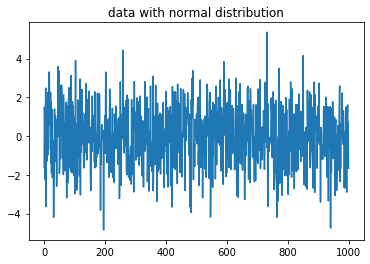

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title("data with normal distribution")
plt.plot(data[0:1000], label='data')
plt.show()

In [26]:
hist

(array([   1,    1,    1,    5,   14,   13,   32,   59,   79,  157,  220,
         339,  523,  753, 1104, 1467, 2052, 2587, 3288, 3923, 4682, 5374,
        5812, 6392, 6675, 6799, 6843, 6486, 6051, 5493, 4803, 4125, 3455,
        2778, 2123, 1765, 1193,  844,  639,  393,  241,  158,  121,   64,
          32,   17,   13,    3,    3,    5], dtype=int64),
 array([-6.61040116, -6.35264232, -6.09488348, -5.83712464, -5.5793658 ,
        -5.32160696, -5.06384812, -4.80608928, -4.54833044, -4.2905716 ,
        -4.03281276, -3.77505392, -3.51729508, -3.25953624, -3.0017774 ,
        -2.74401856, -2.48625972, -2.22850088, -1.97074205, -1.71298321,
        -1.45522437, -1.19746553, -0.93970669, -0.68194785, -0.42418901,
        -0.16643017,  0.09132867,  0.34908751,  0.60684635,  0.86460519,
         1.12236403,  1.38012287,  1.63788171,  1.89564055,  2.15339939,
         2.41115823,  2.66891707,  2.92667591,  3.18443475,  3.44219359,
         3.69995243,  3.95771127,  4.21547011,  4.47322895,  

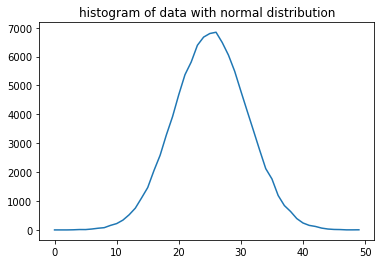

In [27]:
plt.title("histogram of data with normal distribution")
plt.plot(hist[0], label='histogram')
plt.show()

what is `hist[1]`?

The answer to your homework is a single API call:

`scipy.stats.rv_histogram` is a neat API: It produces a pdf from a histogram.

> Huh?! Yup, `scipy.stats.rv_histogram` is essentially the answer to your homework. A single API call! If you only knew your libraries, imagine how much GoT you could watch if you knew all the APIs that exist!

In [28]:
hist_dist = scipy.stats.rv_histogram(hist)

`hist_dist` behaves like an ordinary scipy rv_continuous distribution. For example, we can obtain its pdf (probability of obtaining a value) and cdf (probability of obtaining any value *below* a specific value):

In [29]:
hist_dist.pdf(1.0)

0.21310617324701467

In [30]:
 hist_dist.cdf(0.0)

0.4994298986454626

PDF is zero after the last bin of the histogram, and also before the first bin of the histogram, defined by the max and min of the original dataset:

In [31]:
print(hist_dist.pdf(np.max(data)))
print(hist_dist.cdf(np.max(data)))
print(hist_dist.pdf(np.min(data)))
print(hist_dist.cdf(np.min(data)))

0.0
1.0
3.8795953622249164e-05
0.0


Let's plot the PDF ***on top of*** the histogram we obtained from our data to see if it matches:

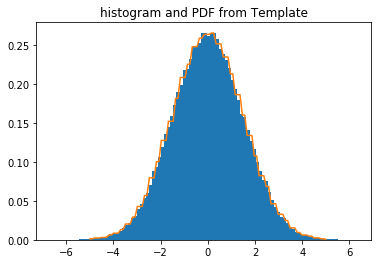

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-5.0, 5.0, 100)
plt.title("histogram and PDF from Template")
plt.hist(data, density=True, bins=100)
plt.plot(X, hist_dist.pdf(X), label='PDF')
plt.show()

Now let's also plot the CDF on top of the histogram we obtained from our data:

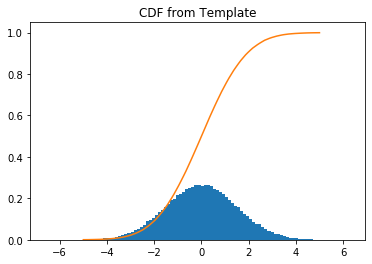

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-5.0, 5.0, 100)
plt.title("CDF from Template")
plt.hist(data, density=True, bins=100)
plt.plot(X, hist_dist.cdf(X), label='CDF')
plt.show()

Notice how the ***0.5 value of the cdf*** is right above the mean of your histogram! The probability of getting *exactly* the mean value of the dataset is exactly 50% because our histogram is balanced and not *skewed* to the right or the left: Same amount of data to the right and to the left of the histogram. 

We'll revisit this fact further below in the notebook, so keep this in mind.

## 2. Intuition

To really do your homework, what you need to create is a **lookup table**. The histogram gives us bins of frequency. When we generate random variates, we lookup those bins *with priority proportional to how big they are*. 

The intuition comes from genetic algorithms' (GA) roulette wheel, a.k.a. [fitness-proportionate selection](https://en.wikipedia.org/wiki/Fitness_proportionate_selection), as we will see further down.

Anyway, this is our *input* histogram:

In [34]:
hist

(array([   1,    1,    1,    5,   14,   13,   32,   59,   79,  157,  220,
         339,  523,  753, 1104, 1467, 2052, 2587, 3288, 3923, 4682, 5374,
        5812, 6392, 6675, 6799, 6843, 6486, 6051, 5493, 4803, 4125, 3455,
        2778, 2123, 1765, 1193,  844,  639,  393,  241,  158,  121,   64,
          32,   17,   13,    3,    3,    5], dtype=int64),
 array([-6.61040116, -6.35264232, -6.09488348, -5.83712464, -5.5793658 ,
        -5.32160696, -5.06384812, -4.80608928, -4.54833044, -4.2905716 ,
        -4.03281276, -3.77505392, -3.51729508, -3.25953624, -3.0017774 ,
        -2.74401856, -2.48625972, -2.22850088, -1.97074205, -1.71298321,
        -1.45522437, -1.19746553, -0.93970669, -0.68194785, -0.42418901,
        -0.16643017,  0.09132867,  0.34908751,  0.60684635,  0.86460519,
         1.12236403,  1.38012287,  1.63788171,  1.89564055,  2.15339939,
         2.41115823,  2.66891707,  2.92667591,  3.18443475,  3.44219359,
         3.69995243,  3.95771127,  4.21547011,  4.47322895,  

In [35]:
hist[0]

array([   1,    1,    1,    5,   14,   13,   32,   59,   79,  157,  220,
        339,  523,  753, 1104, 1467, 2052, 2587, 3288, 3923, 4682, 5374,
       5812, 6392, 6675, 6799, 6843, 6486, 6051, 5493, 4803, 4125, 3455,
       2778, 2123, 1765, 1193,  844,  639,  393,  241,  158,  121,   64,
         32,   17,   13,    3,    3,    5], dtype=int64)

Here is my *first cut* at the function: The idea was to create a number of workers, and to have workers work an amount of time proportional to the histogram. Then we interrupt the coroutine that represents their work (by yielding) and see which worker was active. The lazy workers (short bins) are already done and are probably sleeping, while the very active workers (tall bins) are still working. Those are the workers (bins) I want to pick values from!

<br />
<center>
<img src="https://media0.giphy.com/media/oDrajdEXgcAvK/source.gif" width=400 />
    Working, working, working...
</center>

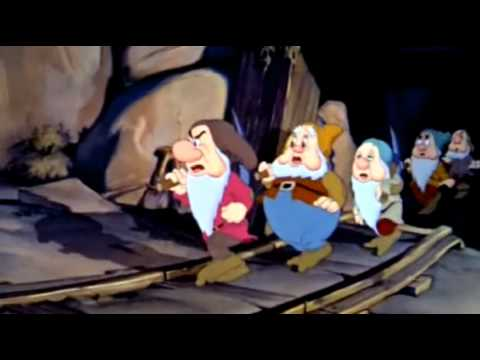

In [36]:
from IPython.display import YouTubeVideo
YouTubeVideo('HI0x0KYChq4')

And as soon as I finished writing this, I thought *this is exactly GA roulette wheel selection*! Here it is, as simple as possible:

In [37]:
hsgm = hist[0]

class Chromosome:
    def __init__(self, idx, fit):
        self.fitness = fit
        self.index = idx
        
Chromosomes = []

# this is ugly python
#i = 0
#for _ in hsgm:
#    Chromosomes.append(Chromosome(i, _))
#    i += 1

# this is pretty python
for i, _ in enumerate(hsgm):
    Chromosomes.append(Chromosome(i, _))

What's the index of the 9$^{th}$ bin, and what is its size? Write the code below:

In [38]:
Chromosomes[9].index,Chromosomes[9].fitness

(9, 157)

Now, how to randomly pick a bin so that most of the time you pick a tall bin? Looat the API of [np.random.choice](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html) and write the code here below to return a Chromosome from a tall bin more often than one from a short bin: 

>**HINT**: First renormalize chromosomes (using a list comprehension) so that their fitness becomes a probability distriubution (so, sums to 1), then use [np.random.choice](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html) to return a chromosome from a tall bin since you can now pass the API a probability distribution.

In [39]:
def selectOne(population):
    maximum = sum([c.fitness for c in population])
    selection_probs = [c.fitness/maximum for c in population]
    return population[np.random.choice(len(population), p=selection_probs)]

<div style="visibility: hidden">
def selectOne(population):
    maximum = sum([c.fitness for c in population])
    selection_probs = [c.fitness/maximum for c in population]
    return population[np.random.choice(len(population), p=selection_probs)]
</div>

Now let's test that function and see if it returns what we want:
```(python)
c = selectOne(Chromosomes)
c.index, c.fitness
```

In [41]:
c = selectOne(Chromosomes)
c.index, c.fitness

(34, 2123)

Here is a full algorithm without "*cheating*" by using `np.random.choice`. Copy and paste each code snippet into the code cell further below.

First, sort the weights in ascending order: This gives you indeces and weights based on weights in ascending order: We use python's `sorted` API, follwed by the zipper to get both index and weight (height of the bin):
```(python)
    sorted_indexed_weights = sorted(enumerate(weights), key=operator.itemgetter(1));
    indices, sorted_weights = zip(*sorted_indexed_weights);
```

Then we calculate the cumulative probability (note that is a cdf!). Essentially, we convert  weights to a pdf, then to a cdf. A cdf is useful because the tallest bin in the distribution (the mean) is associated with a cdf value of 0.5. We leverage `Numpy`'s [cumsum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html) API
```(python)
    tot_sum = np.sum(sorted_weights)
    prob = [x/tot_sum for x in sorted_weights]
    cum_prob = np.cumsum(prob)
```

Now we select a random a number in the range \[0,1\]:
```(python)
    random_num = random.random()
```

Now we go through the cdf. As soon as we find a bin where the cdf value exceeds our random float, return the index
of that bin:
```(python)
    for index_value, cum_prob_value in zip(indices, cum_prob):
        if random_num < cum_prob_value:
            return index_value
```

In [42]:
import random
import operator

def roulette_selection(weights):
    '''performs roulette wheel selection on a list, returns the index selected from the list'''
    sorted_indexed_weights = sorted(enumerate(weights), key=operator.itemgetter(1));
    indices, sorted_weights = zip(*sorted_indexed_weights);
    tot_sum = np.sum(sorted_weights)
    prob = [x/tot_sum for x in sorted_weights]
    cum_prob = np.cumsum(prob)
    random_num = random.random()
    for index_value, cum_prob_value in zip(indices, cum_prob):
            if random_num < cum_prob_value:
                return index_value

    

    
    
    
    
    
    
    
    
    
    

Let's walk through this algorithm block by block:

In [43]:
hsgm = hist[0]
sorted_indexed_weights = sorted(enumerate(hsgm), key=operator.itemgetter(1))
'; '.join(['('+str(p)+', '+str(q)+')' for (p,q) in sorted_indexed_weights])

'(0, 1); (1, 1); (2, 1); (47, 3); (48, 3); (3, 5); (49, 5); (5, 13); (46, 13); (4, 14); (45, 17); (6, 32); (44, 32); (7, 59); (43, 64); (8, 79); (42, 121); (9, 157); (41, 158); (10, 220); (40, 241); (11, 339); (39, 393); (12, 523); (38, 639); (13, 753); (37, 844); (14, 1104); (36, 1193); (15, 1467); (35, 1765); (16, 2052); (34, 2123); (17, 2587); (33, 2778); (18, 3288); (32, 3455); (19, 3923); (31, 4125); (20, 4682); (30, 4803); (21, 5374); (29, 5493); (22, 5812); (28, 6051); (23, 6392); (27, 6486); (24, 6675); (25, 6799); (26, 6843)'

In [44]:
indices, sorted_weights = zip(*sorted_indexed_weights);
', '.join([str(i) for i in indices])

'0, 1, 2, 47, 48, 3, 49, 5, 46, 4, 45, 6, 44, 7, 43, 8, 42, 9, 41, 10, 40, 11, 39, 12, 38, 13, 37, 14, 36, 15, 35, 16, 34, 17, 33, 18, 32, 19, 31, 20, 30, 21, 29, 22, 28, 23, 27, 24, 25, 26'

In [45]:
', '.join([str(i) for i in sorted_weights])

'1, 1, 1, 3, 3, 5, 5, 13, 13, 14, 17, 32, 32, 59, 64, 79, 121, 157, 158, 220, 241, 339, 393, 523, 639, 753, 844, 1104, 1193, 1467, 1765, 2052, 2123, 2587, 2778, 3288, 3455, 3923, 4125, 4682, 4803, 5374, 5493, 5812, 6051, 6392, 6486, 6675, 6799, 6843'

In [46]:
tot_sum = np.sum(sorted_weights)
prob = [x/tot_sum for x in sorted_weights]
cum_prob = np.cumsum(prob)
cum_prob

array([1.0000e-05, 2.0000e-05, 3.0000e-05, 6.0000e-05, 9.0000e-05,
       1.4000e-04, 1.9000e-04, 3.2000e-04, 4.5000e-04, 5.9000e-04,
       7.6000e-04, 1.0800e-03, 1.4000e-03, 1.9900e-03, 2.6300e-03,
       3.4200e-03, 4.6300e-03, 6.2000e-03, 7.7800e-03, 9.9800e-03,
       1.2390e-02, 1.5780e-02, 1.9710e-02, 2.4940e-02, 3.1330e-02,
       3.8860e-02, 4.7300e-02, 5.8340e-02, 7.0270e-02, 8.4940e-02,
       1.0259e-01, 1.2311e-01, 1.4434e-01, 1.7021e-01, 1.9799e-01,
       2.3087e-01, 2.6542e-01, 3.0465e-01, 3.4590e-01, 3.9272e-01,
       4.4075e-01, 4.9449e-01, 5.4942e-01, 6.0754e-01, 6.6805e-01,
       7.3197e-01, 7.9683e-01, 8.6358e-01, 9.3157e-01, 1.0000e+00])

In [47]:
', '.join([str(i) for i in prob])

'1e-05, 1e-05, 1e-05, 3e-05, 3e-05, 5e-05, 5e-05, 0.00013, 0.00013, 0.00014, 0.00017, 0.00032, 0.00032, 0.00059, 0.00064, 0.00079, 0.00121, 0.00157, 0.00158, 0.0022, 0.00241, 0.00339, 0.00393, 0.00523, 0.00639, 0.00753, 0.00844, 0.01104, 0.01193, 0.01467, 0.01765, 0.02052, 0.02123, 0.02587, 0.02778, 0.03288, 0.03455, 0.03923, 0.04125, 0.04682, 0.04803, 0.05374, 0.05493, 0.05812, 0.06051, 0.06392, 0.06486, 0.06675, 0.06799, 0.06843'

In [48]:
', '.join([str(round(i,2)) for i in cum_prob])

'0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.12, 0.14, 0.17, 0.2, 0.23, 0.27, 0.3, 0.35, 0.39, 0.44, 0.49, 0.55, 0.61, 0.67, 0.73, 0.8, 0.86, 0.93, 1.0'

Now select a random float in \[0, 1\]:

In [51]:
random_num = random.random()
random_num

0.3245673316143376

>Why is this algorithm called **roulette wheel** or ***fitness proportionate*** selection? Because if you decided to use a random number generator to select your next boyfriend/girlfriend and somebody told you that you need to include the eventuality of getting a boyfriend/girlfriend that you dont like that much, you would want to use a normal distribution and assign the bins closer to the mean to the prettiest possible girls and boys, right?

That's the level of fitness you ***expect*** (expectation) for your next boyfriend/girlfriend! In the code above, the first entry in the list above which is bigger than a random level of fitness with expectation = 0.5 (expectation of a normal random number generator)! 

<br />
<center>
<img src="https://media3.giphy.com/media/l0HlIAWUuhUccrtDO/giphy.gif" width=300 />
</center>

This is the same thing as spinning a roulette wheel with pieces of the pie assigned proportionately to prettier people and seeing which piece of the pie it lands on after a spin!

<br />
<center>
<img src="https://www.researchgate.net/publication/311245613/figure/fig3/AS:566020097220608@1511961115040/Roulette-wheel-selection-based-on-fitness.png" width=400 />
</center>

What is the expectation for your random number? 0.5, right? You can see that 0.5 lands you right next to the "*big*" bins, the ones with big fitness values.

In [52]:
for index_value, cum_prob_value in zip(indices, cum_prob):
    if random_num < cum_prob_value:
        print(index_value)
        break

31


In [53]:
len(hist[0])

50

Now run the cell below *many many* times and see if it gives you *most of the time*, indeces close to halh the size of your histogram:

In [54]:
roulette_selection(hist[0])

19

The input to your homework function is a histogram $h$ (with any number of bins), a range $r$ to generate values from, and the number $n$ of desired random variates.

Now, break down the input interval into *as many intervals as there are bins in the input histogram*. Then we use roulette wheel selection to pick one of these bins. Then generate a random float within the interval of that bin, and that is our first random variate!

Use the following inputs:
```(python)
# inputs
h = hsgm
r = range(-23, 23)
n = 10000
```

Now subdivide the x axis in the r range into `len(hsgm)` bins by using the `np.inspace` API nd verify that `x[0], x[len(hsgm)//2], x[len(hsgm)-1]` are the values you expected for the range `r`:

In [55]:
# inputs
h = hsgm
r = range(-23, 23)
n = 10000

Then call `i = roulette_selection(h)` many times and `print(i)`. Also, add the following below (why do we do this?):
```(python)
if i == len(hsgm) - 1: i -= 1
x[i], x[i+1]
```

In [58]:
if i == len(hsgm) - 1: i -= 1
x[i], x[i+1]

NameError: name 'x' is not defined

Now generate random values **uniformly** (using `random.uniform`) API to generate random values from the interval `x[i], x[i+1]`:

In [63]:
x = np.linspace(r.start, r.stop, n)
x[0], 

(-23.0,)

<div style="visibility:hidden">
random.uniform(x[i], x[i+1])
</div>

Ready?

Now, generate a list of random variates whose distribution will look like our initial normal distribution `h`:
```python)
my_random_variates = []
for _ in range(n):
    i = roulette_selection(h)
    if i == len(hsgm) - 1: i -= 1
    my_random_variates.append(random.uniform(x[i], x[i+1]))
```

In [64]:
my_random_variates = []
for _ in range(n):
    i = roulette_selection(h)
    if i == len(hsgm) - 1: i -= 1
    my_random_variates.append(random.uniform(x[i], x[i+1]))

Now plot the random variates:

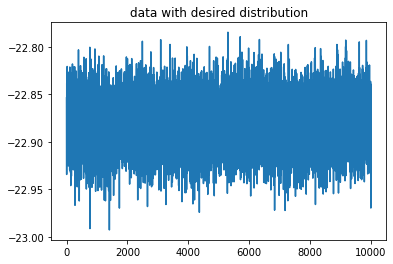

In [65]:
plt.title("data with desired distribution")
plt.plot(my_random_variates, label='data')
plt.show()

Now plot the histogram of our random variates and superimpose that on top of our input histogram. Use the following renormalization so that the maximums of both histograms (*input* and *generated*) match:
```(python)
plt.plot(hsgm * max(my_not_so_random_histogram[0]) / max(hsgm), label='original histogram')
```

In [66]:
my_not_so_random_histogram = np.histogram(my_random_variates, bins=len(hsgm))

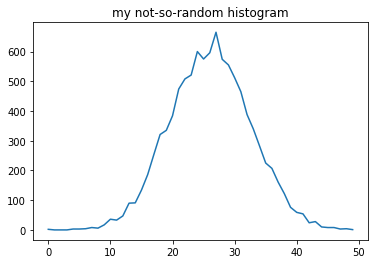

In [67]:
plt.title("my not-so-random histogram")
plt.plot(my_not_so_random_histogram[0], label='histogram')
...
plt.show()

And... what if we generate ten times more datapoints, say 100,000?
```(python)
my_random_variates = []
for _ in range(n * 10):
    i = roulette_selection(h)
    if i == len(hsgm) - 1: i -= 1
    my_random_variates.append(random.uniform(x[i], x[i+1]))
    
my_not_so_random_histogram = np.histogram(my_random_variates, bins=len(hsgm))

plt.title("my not-so-random and also improved histogram")
plt.plot(my_not_so_random_histogram[0], label='generated histogram')
plt.plot(hsgm * max(my_not_so_random_histogram[0]) / max(hsgm), label='original histogram')
plt.show()
```

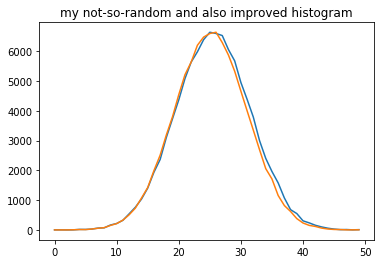

In [70]:
my_random_variates = []
for _ in range(n * 10):
    i = roulette_selection(h)
    if i == len(hsgm) - 1: i -= 1
    my_random_variates.append(random.uniform(x[i], x[i+1]))

my_not_so_random_histogram = np.histogram(my_random_variates, bins=len(hsgm))

plt.title("my not-so-random and also improved histogram")
plt.plot(my_not_so_random_histogram[0], label='generated histogram')
plt.plot(hsgm * max(my_not_so_random_histogram[0]) / max(hsgm), label='original histogram')
plt.show()

Getting closer and closer the more random variates I produce! This is the key to *frequentist statistics*. If i have tons of data, then I'm in good shape. However, *when we don't have enough data*, which is the *sweet spot( of state of the art ML, that is when we turn to *Bayesian statistics*!

## Yang Huang's function

This is a student's function, who wondered why we had to do roulette wheel selection:

In [71]:
import random
## This function takes a histogram 'A'(tuple), size of fakedata 'N'(int) and the range of fakedata 'R' (tuple) as input
def fakeData(A, N, R):
    nOfBins = A[0].size
    sum = 0
    for _ in A[0]:
        sum +=_
    ## n is the size of original dataset
    n = sum 
    
    ## set the frequency in fake dataset
    frequency = []
    for i in range(nOfBins):
        frequency.append(A[0][i]/n*N)
        
    ## set the width of bins in new dataset
    w = (R[1]-R[0])/nOfBins
    
    ## set ranges for new bins
    ranges = []
    for i in range(nOfBins+1):
        ranges.append(R[0] + i*w)
        
    ## create fakedata   
    data = []
    #this is beautiful python
    for m, i in enumerate(frequency):
        for _ in range(int(i)):
            data.append(random.uniform(ranges[m],ranges[m+1]))
    
    return data          

Let's examine what Yang's function does:

In [72]:
hist[0]

array([   1,    1,    1,    5,   14,   13,   32,   59,   79,  157,  220,
        339,  523,  753, 1104, 1467, 2052, 2587, 3288, 3923, 4682, 5374,
       5812, 6392, 6675, 6799, 6843, 6486, 6051, 5493, 4803, 4125, 3455,
       2778, 2123, 1765, 1193,  844,  639,  393,  241,  158,  121,   64,
         32,   17,   13,    3,    3,    5], dtype=int64)

In [73]:
N = 10000
R = [-23, 23]
nOfBins = hist[0].size
sum = 0
for _ in hist[0]:
    sum +=_
## n is the size of original dataset
n = sum 
n

100000

>**CORRECTION**: n is the **cumsum** (or cumulative sum) of the histogram, ***not*** the size of of the dataset, which is `len(hist[0]) = 100`

In [74]:
frequency = []
for i in range(nOfBins):
    frequency.append(hist[0][i]/n*N)
frequency

[0.1,
 0.1,
 0.1,
 0.5,
 1.4,
 1.2999999999999998,
 3.2,
 5.9,
 7.9,
 15.7,
 22.0,
 33.9,
 52.300000000000004,
 75.3,
 110.39999999999999,
 146.70000000000002,
 205.2,
 258.7,
 328.8,
 392.3,
 468.2,
 537.4,
 581.1999999999999,
 639.2,
 667.5,
 679.9,
 684.3000000000001,
 648.6,
 605.1,
 549.3,
 480.3,
 412.5,
 345.5,
 277.8,
 212.29999999999998,
 176.5,
 119.3,
 84.39999999999999,
 63.9,
 39.300000000000004,
 24.099999999999998,
 15.8,
 12.1,
 6.4,
 3.2,
 1.7000000000000002,
 1.2999999999999998,
 0.3,
 0.3,
 0.5]

So it appears `frequency` is just a *rescaled* histogram.

In [75]:
## set the width of bins in new dataset
w = (R[1]-R[0])/nOfBins
w

0.92

So we will generate values from intervals of size `w` above, with frequency proportional to the size of the corresponding histogram bin! So far, so good!

In [76]:
## set ranges for new bins
ranges = []
for i in range(nOfBins+1):
    ranges.append(R[0] + i*w)
ranges

[-23.0,
 -22.08,
 -21.16,
 -20.24,
 -19.32,
 -18.4,
 -17.48,
 -16.56,
 -15.64,
 -14.719999999999999,
 -13.799999999999999,
 -12.879999999999999,
 -11.959999999999999,
 -11.04,
 -10.12,
 -9.2,
 -8.28,
 -7.359999999999999,
 -6.439999999999998,
 -5.52,
 -4.599999999999998,
 -3.6799999999999997,
 -2.759999999999998,
 -1.8399999999999999,
 -0.9199999999999982,
 0.0,
 0.9200000000000017,
 1.8399999999999999,
 2.7600000000000016,
 3.6799999999999997,
 4.600000000000001,
 5.52,
 6.440000000000001,
 7.360000000000003,
 8.280000000000001,
 9.200000000000003,
 10.120000000000005,
 11.04,
 11.96,
 12.880000000000003,
 13.800000000000004,
 14.719999999999999,
 15.64,
 16.560000000000002,
 17.480000000000004,
 18.4,
 19.32,
 20.240000000000002,
 21.160000000000004,
 22.080000000000005,
 23.0]

And those are the intervals we will generate values from. Grrrrrrrrrrrreat!

In [77]:
## create fakedata   
data = []
#this is beautiful python
for m, i in enumerate(frequency):
    for _ in range(int(i)):
        data.append(random.uniform(ranges[m],ranges[m+1]))
data

[-18.950466156484225,
 -17.560274368375175,
 -17.251026148004605,
 -17.134520952862015,
 -16.641307045322353,
 -15.695325214522171,
 -16.19259584190412,
 -15.82367949715315,
 -16.527796511643448,
 -16.198860049511953,
 -15.259988557422206,
 -15.108545934475616,
 -14.72559635793148,
 -15.474895834620494,
 -15.505192619865058,
 -15.026383599577045,
 -15.07964794445056,
 -13.976848078978339,
 -14.242136210495874,
 -14.070869807515018,
 -14.126776148361863,
 -14.11125384464492,
 -14.21429055936719,
 -14.658384280792182,
 -13.94708004218001,
 -14.340494215935568,
 -14.03749326622051,
 -14.207944261009647,
 -14.12362725214818,
 -14.471314009236407,
 -14.555859213614548,
 -14.26651762038325,
 -13.635408686176746,
 -13.63240350063775,
 -13.49386562325973,
 -12.919573629252556,
 -13.373271416892504,
 -13.370971239317848,
 -13.355256082760743,
 -13.264018003132383,
 -13.69001616908798,
 -13.407287875059318,
 -13.354146503749817,
 -13.183485432025607,
 -12.967573699063736,
 -12.953167582925172,
 

`for m, i in enumerate(frequency):` essentially goes through the original histogram and gets the bin index `m` and the bin count `i`.

In that outer loop. `for _ in range(int(i)):` ranges the bin count. So it's a much larger range of numbers for big bins (bins with big values), and a much smaller range of numbers for small bins. In other words, what happens under the `for` loop will happen ***more often*** when we're visiting big bins than when we're visiting small bins. In other words, this is **roulette wheel selection**.

In that inner loop, `random.uniform(ranges[m],ranges[m+1])` selects a single random number, with uniform probability between `ranges[m]` and `ranges[m+1]`:

In [78]:
print(ranges[10],ranges[11])
random.uniform(ranges[10],ranges[11])

-13.799999999999999 -12.879999999999999


-13.153860320665746

Finally, `data.append` appends the value to our list of generated numbers.

<br />
<center>
<img src="https://media1.giphy.com/media/9xuUhwozi3qvJdPogI/giphy.gif" width=400 />
</center>

Let's test!

(array([1.27078894e-05, 6.35394468e-06, 3.17697234e-05, 6.98933915e-05,
        3.81236681e-05, 1.71556506e-04, 3.49466958e-04, 4.51130073e-04,
        8.19658864e-04, 1.26443499e-03, 1.85535185e-03, 2.81479749e-03,
        4.20631138e-03, 5.94729222e-03, 8.41897671e-03, 1.10050322e-02,
        1.45759491e-02, 1.85535185e-02, 2.26327510e-02, 2.72901924e-02,
        3.07467383e-02, 3.51944996e-02, 3.78377406e-02, 4.08431564e-02,
        4.20440520e-02, 4.24379965e-02, 4.20249901e-02, 3.90386361e-02,
        3.67321542e-02, 3.32629004e-02, 2.87452457e-02, 2.43419621e-02,
        2.05105334e-02, 1.61834971e-02, 1.27777828e-02, 1.01980812e-02,
        6.95121548e-03, 5.13398730e-03, 3.64081030e-03, 2.19846486e-03,
        1.49953095e-03, 9.78507481e-04, 6.92579971e-04, 3.93944570e-04,
        1.84264396e-04, 1.01663115e-04, 6.98933915e-05, 1.90618341e-05,
        1.90618341e-05, 3.17697234e-05]),
 array([-38.69941309, -37.12547744, -35.55154179, -33.97760615,
        -32.4036705 , -30.8297

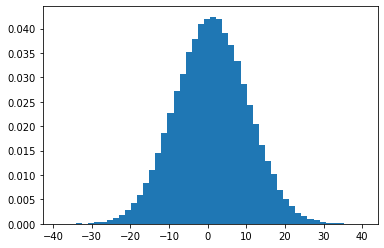

In [79]:
fakedata = fakeData(hist, 100000, (-40,40))
hist = np.histogram(fakedata, bins=hist[0].size)
plt.hist(fakedata, density=True, bins=50)

Let's *compare*:

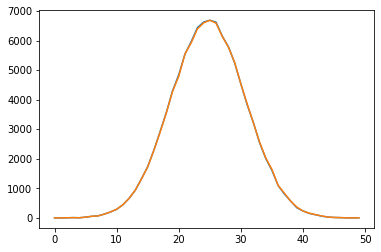

In [80]:
hist_in = hist
fakedata = fakeData(hist, 100000, (-40,40))
hist_out = np.histogram(fakedata, bins=hist[0].size)
plt.plot(hist_in[0] * max(hist_out[0]) / max(hist_in[0]), label='input histogram')
plt.plot(hist_out[0], label='output histogram')

Wow!

Let's compare with professor's solution:

In [81]:
hist[0]

array([   2,    1,    5,   11,    6,   27,   55,   71,  129,  199,  292,
        443,  662,  936, 1325, 1732, 2294, 2920, 3562, 4295, 4839, 5539,
       5955, 6428, 6617, 6679, 6614, 6144, 5781, 5235, 4524, 3831, 3228,
       2547, 2011, 1605, 1094,  808,  573,  346,  236,  154,  109,   62,
         29,   16,   11,    3,    3,    5], dtype=int64)

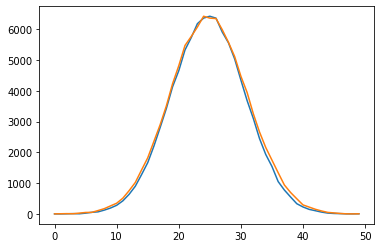

In [82]:
def fake_data_professor(A, N, R):
    my_random_variates = []
    x = np.linspace(R[0], R[1], len(A[0]))
    for _ in range(N):
        i = roulette_selection(A[0])
        if i == len(A[0]) - 1: i -= 1
        my_random_variates.append(random.uniform(x[i], x[i+1]))
    return my_random_variates

hist_in = hist
fakedataprofessor = fake_data_professor(hist_in, 100000, (-40,40))   
hist_out = np.histogram(fakedataprofessor, bins=hist[0].size)
plt.plot(hist_in[0] * max(hist_out[0]) / max(hist_in[0]), label='input histogram')
plt.plot(hist_out[0], label='output histogram')

Yang Huang's solution is *faster* and matches the input histogram *better*!

But... did Yang test *all possible inputs*? What if the random variate dataset size is *less* than the length of the histogram?

For example, try:
- `hist = np.histogram(data, bins=100)` and `fakedata = fakeData(hist, 300, (-40,40))`
- `hist = np.histogram(data, bins=1000)` and `fakedata = fakeData(hist, 750, (-40,40))`

### *Homework*
Compare Yang's solution with professor's solution. How would you improve Yang's solution so that it is closer to the desired output?

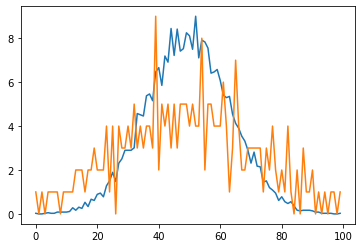

In [83]:
hist = np.histogram(data, bins=100)

hist_in = hist
fakedata = fakeData(hist, 300, (-40,40))
hist_out1 = np.histogram(fakedata, bins=hist[0].size)
plt.plot(hist_in[0] * max(hist_out1[0]) / max(hist_in[0]), label='input histogram')
plt.plot(hist_out1[0], label='output histogram')

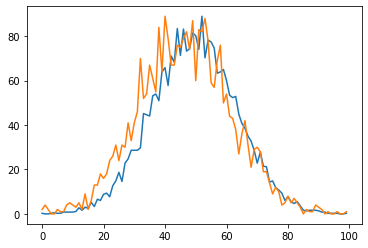

In [84]:
hist_in = hist
fakedataprofessor = fake_data_professor(hist_in, 3000, (-40,40))   
hist_out2 = np.histogram(fakedataprofessor, bins=hist[0].size)
plt.plot(hist_in[0] * max(hist_out2[0]) / max(hist_in[0]), label='input histogram')
plt.plot(hist_out2[0], label='output histogram')

## 3. Random variates from histogram

Ok, we wrote the *prototype*, but now we're ready to write a general class that leverages key probability concepts such as **pdf** and **cdf**, does some unit testing, etc.

The following class will generate random variates, given a histogram. Note how I reduced tab spaces, long notebook cells are prettier that way.

In [85]:
import pylab
import numpy

class GeneralRandom:
  """This class enables us to generate random numbers with an arbitrary 
  distribution."""
  
  def __init__(self, x = pylab.arange(-1.0, 1.0, .01), p = None, Nrl = 1000):
    """Initialize the lookup table (with default values if necessary)
    Inputs:
    x = random number values
    p = probability density profile at that point
    Nrl = number of reverse look up values between 0 and 1"""  
    
    if not isinstance(p, numpy.ndarray):
        if not isinstance(p, tuple):
            if p == None:
                p = pylab.exp(-10*x**2.0)
    self.set_pdf(x, p, Nrl)
   

  def set_pdf(self, x, p, Nrl = 1000):
    """Generate the lookup tables. 
    x is the value of the random variate
    pdf is its probability density
    cdf is the cumulative pdf
    inversecdf is the inverse look up table"""
    
    self.x = x
    if isinstance(p, tuple):
        self.pdf = p/sum(p) #normalize it
    else:
        self.pdf = p/p.sum() #normalize it
        
    self.cdf = self.pdf.cumsum()
    self.inversecdfbins = Nrl
    self.Nrl = Nrl
    
    y = pylab.arange(Nrl)/float(Nrl)
    delta = 1.0/Nrl
    self.inversecdf = pylab.zeros(Nrl)    
    self.inversecdf[0] = self.x[0]
    cdf_idx = 0
    
    for n in range(1,self.inversecdfbins):
        while self.cdf[cdf_idx] < y[n] and cdf_idx < Nrl:
            cdf_idx += 1
        self.inversecdf[n] = self.x[cdf_idx-1] + (
            self.x[cdf_idx] - self.x[cdf_idx-1]) * (y[n] - self.cdf[cdf_idx-1])/(self.cdf[cdf_idx] - self.cdf[cdf_idx-1]) 
        if cdf_idx >= Nrl:
            break
    self.delta_inversecdf = pylab.concatenate((pylab.diff(self.inversecdf), [0]))
              
  def random(self, N = 1000):
    """Give us N random numbers with the requested distribution"""

    idx_f = numpy.random.uniform(size = N, high = self.Nrl-1)
    idx = pylab.array([idx_f],'i')
    y = self.inversecdf[idx] + (idx_f - idx)*self.delta_inversecdf[idx]

    return y
  
  def plot_pdf(self):
    pylab.plot(self.x, self.pdf)
    
  def self_test(self, N = 1000):
    pylab.figure()
    #The cdf
    pylab.subplot(2,2,1)
    pylab.plot(self.x, self.cdf)
    #The inverse cdf
    pylab.subplot(2,2,2)
    y = pylab.arange(self.Nrl)/float(self.Nrl)
    pylab.plot(y, self.inversecdf)
    
    #The actual generated numbers
    pylab.subplot(2,2,3)
    y = self.random(N)
    p1, edges = pylab.histogram(y, bins = 50, 
                                range = (self.x.min(), self.x.max()), 
                                normed = True)
    x1 = 0.5*(edges[0:-1] + edges[1:])
    pylab.plot(x1, p1/p1.max())
    pylab.plot(self.x, self.pdf/self.pdf.max())

C:\Users\92967\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


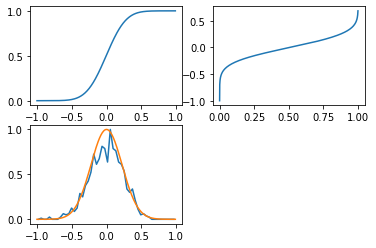

In [86]:
test = GeneralRandom()
test.self_test()

In [87]:
x = pylab.arange(-1.0, 1.0, .01)
pylab.exp(-10*x**2.0)

array([4.53999298e-05, 5.53961755e-05, 6.74583627e-05, 8.19828893e-05,
       9.94356357e-05, 1.20362805e-04, 1.45403198e-04, 1.75302063e-04,
       2.10926674e-04, 2.53283790e-04, 3.03539138e-04, 3.63039106e-04,
       4.33334765e-04, 5.16208399e-04, 6.13702669e-04, 7.28152539e-04,
       8.62220086e-04, 1.01893226e-03, 1.20172170e-03, 1.41447053e-03,
       1.66155727e-03, 1.94790664e-03, 2.27904223e-03, 2.66114180e-03,
       3.10109501e-03, 3.60656314e-03, 4.18604042e-03, 4.84891651e-03,
       5.60553935e-03, 6.46727781e-03, 7.44658307e-03, 8.55704807e-03,
       9.81346359e-03, 1.12318701e-02, 1.28296036e-02, 1.46253347e-02,
       1.66390989e-02, 1.88923160e-02, 2.14077987e-02, 2.42097460e-02,
       2.73237224e-02, 3.07766190e-02, 3.45965954e-02, 3.88130014e-02,
       4.34562758e-02, 4.85578213e-02, 5.41498541e-02, 6.02652275e-02,
       6.69372276e-02, 7.41993418e-02, 8.20849986e-02, 9.06272807e-02,
       9.98586094e-02, 1.09810404e-01, 1.20512717e-01, 1.31993843e-01,
      

In [88]:
type(data)

list

In [89]:
data

[-18.950466156484225,
 -17.560274368375175,
 -17.251026148004605,
 -17.134520952862015,
 -16.641307045322353,
 -15.695325214522171,
 -16.19259584190412,
 -15.82367949715315,
 -16.527796511643448,
 -16.198860049511953,
 -15.259988557422206,
 -15.108545934475616,
 -14.72559635793148,
 -15.474895834620494,
 -15.505192619865058,
 -15.026383599577045,
 -15.07964794445056,
 -13.976848078978339,
 -14.242136210495874,
 -14.070869807515018,
 -14.126776148361863,
 -14.11125384464492,
 -14.21429055936719,
 -14.658384280792182,
 -13.94708004218001,
 -14.340494215935568,
 -14.03749326622051,
 -14.207944261009647,
 -14.12362725214818,
 -14.471314009236407,
 -14.555859213614548,
 -14.26651762038325,
 -13.635408686176746,
 -13.63240350063775,
 -13.49386562325973,
 -12.919573629252556,
 -13.373271416892504,
 -13.370971239317848,
 -13.355256082760743,
 -13.264018003132383,
 -13.69001616908798,
 -13.407287875059318,
 -13.354146503749817,
 -13.183485432025607,
 -12.967573699063736,
 -12.953167582925172,
 

This is our histogram from above: generated through random variates of a normal distribution:

In [90]:
hist[0]

array([  1,   0,   0,   1,   2,   1,   1,   3,   3,   3,   3,   4,  10,
         6,  11,   9,  19,  12,  24,  22,  32,  34,  28,  46,  54,  68,
        53,  83,  90, 104, 104, 104, 108, 164, 162, 160, 193, 196, 185,
       232, 239, 210, 258, 248, 303, 259, 302, 266, 270, 296, 291, 269,
       323, 255, 284, 281, 271, 230, 232, 236, 218, 194, 190, 192, 163,
       148, 140, 127, 119, 104,  83, 101,  78,  77,  52,  54,  43,  39,
        34,  22,  28,  20,  17,  20,  13,   6,   5,   6,   6,   6,   5,
         3,   3,   1,   1,   1,   1,   0,   0,   1], dtype=int64)

In [91]:
type(hist_dist)

scipy.stats._continuous_distns.rv_histogram

In [92]:
hist_dist

So we have a histogram. Let's instantiate the class from that histogram in order to generate simulated data.

C:\Users\92967\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


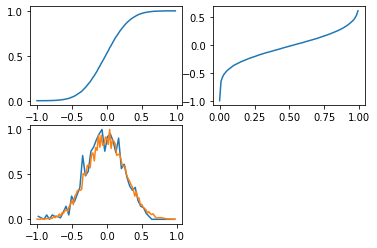

In [93]:
rvs_from_hist = GeneralRandom(x = pylab.arange(-1.0, 1.0, .02), p = hist[0], Nrl = 100)
rvs_from_hist.self_test()

Now let's generate random variates:

In [94]:
sim_data = rvs_from_hist.random()
sim_data

array([[ 1.36334828e-01,  4.32122252e-01,  8.85799412e-02,
         3.93591180e-01, -2.83615447e-01, -1.69425464e-01,
        -3.98016105e-01, -1.01257092e-01,  2.88336026e-02,
         4.48902750e-02, -7.06146564e-03, -1.61648282e-01,
        -1.35019243e-01,  1.95778872e-01, -4.07655423e-01,
         2.13079645e-02, -2.13826221e-01, -3.75802212e-02,
         1.46273345e-01,  7.24318870e-02, -4.08246754e-01,
        -2.86109460e-01, -2.85696997e-01, -3.40863259e-01,
        -2.59061655e-01,  5.42651240e-01, -7.07740068e-03,
        -1.66708667e-01,  2.78252872e-01, -1.50494899e-01,
         1.94229302e-01, -1.19863159e-01, -3.17891395e-01,
         3.48124740e-01, -1.31657131e-01,  2.65230556e-01,
        -3.23586149e-01, -2.41500308e-01, -2.56475718e-01,
         1.20880188e-01,  5.99566452e-02, -1.25548182e-01,
         3.31569781e-01, -2.04054212e-01, -2.41992638e-01,
        -1.70524933e-01,  2.56181336e-01, -2.46116188e-01,
        -2.06513771e-02,  6.51026576e-02, -3.93321969e-0

In [95]:
sim_data[0]

array([ 1.36334828e-01,  4.32122252e-01,  8.85799412e-02,  3.93591180e-01,
       -2.83615447e-01, -1.69425464e-01, -3.98016105e-01, -1.01257092e-01,
        2.88336026e-02,  4.48902750e-02, -7.06146564e-03, -1.61648282e-01,
       -1.35019243e-01,  1.95778872e-01, -4.07655423e-01,  2.13079645e-02,
       -2.13826221e-01, -3.75802212e-02,  1.46273345e-01,  7.24318870e-02,
       -4.08246754e-01, -2.86109460e-01, -2.85696997e-01, -3.40863259e-01,
       -2.59061655e-01,  5.42651240e-01, -7.07740068e-03, -1.66708667e-01,
        2.78252872e-01, -1.50494899e-01,  1.94229302e-01, -1.19863159e-01,
       -3.17891395e-01,  3.48124740e-01, -1.31657131e-01,  2.65230556e-01,
       -3.23586149e-01, -2.41500308e-01, -2.56475718e-01,  1.20880188e-01,
        5.99566452e-02, -1.25548182e-01,  3.31569781e-01, -2.04054212e-01,
       -2.41992638e-01, -1.70524933e-01,  2.56181336e-01, -2.46116188e-01,
       -2.06513771e-02,  6.51026576e-02, -3.93321969e-01,  2.36139002e-01,
       -1.81868816e-01,  

In [96]:
len(sim_data[0])

1000

What does the data look like?

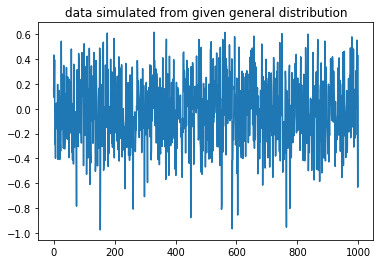

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title("data simulated from given general distribution")
plt.plot(sim_data[0], label='sim_data')
plt.show()

Let's evaluate the histogram from the data, and also use `scipy.stats.rv_histogram` to generate random variates from that histogram:

In [98]:
hist2 = np.histogram(sim_data, bins=100)
hist2_dist = scipy.stats.rv_histogram(hist2)

Let's plot the histogram of the random variates on top of the pdf from random variates from of the histogram of the random variates:

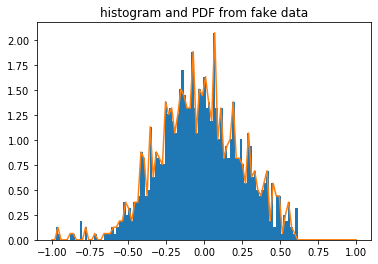

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-1.0, 1.0, 100)
plt.title("histogram and PDF from fake data")
plt.hist(sim_data[0], density=True, bins=100)
plt.plot(X, hist2_dist.pdf(X), label='PDF')
plt.show()

Let's do it again. Now we use the histogram above as the input to our class.

C:\Users\92967\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


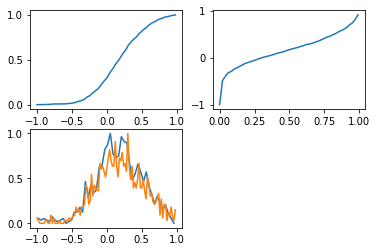

In [100]:
rvs_from_hist2 = GeneralRandom(x = pylab.arange(-1.0, 1.0, .02), p = hist2[0], Nrl = 100)
rvs_from_hist2.self_test()

In [101]:
sim_data2 = rvs_from_hist2.random()
sim_data2

array([[ 7.26157790e-01,  1.45534154e-01,  1.72330142e-01,
        -8.55508507e-02,  2.33699001e-01, -1.75678177e-01,
         5.86886029e-01,  9.58588385e-02, -7.03624811e-02,
         7.12441816e-01,  4.46868291e-01,  4.57243671e-01,
        -6.11548128e-01,  6.33168531e-01,  1.27587419e-01,
        -5.59905397e-02, -8.92836920e-02,  2.02886833e-01,
         7.06294474e-01, -1.98786251e-01, -1.10483258e-01,
        -2.89356020e-01,  4.93201044e-01,  2.79278283e-01,
        -8.81472485e-02, -9.82657594e-02,  5.75191686e-01,
         3.38844140e-01,  4.27279548e-01,  4.82231008e-01,
         8.81408420e-01, -1.01023137e-01,  2.07445567e-01,
        -3.07530397e-01,  5.73962396e-02,  3.37770127e-01,
         1.64040643e-01, -2.84617923e-01, -4.24463028e-01,
         4.57967954e-01,  1.87928564e-01,  2.93587176e-01,
         3.38380800e-01,  6.79326738e-02,  9.07085012e-01,
        -2.30446781e-01, -8.26565505e-01,  8.79414455e-01,
         8.13493491e-01,  5.97651825e-01, -3.06192260e-0

Notice how the histograms degenerate in shape as we continue the process of generating numbers from a histogram, then using the generated numbers to get the new histogram, and using that as input to the same process.

In [102]:
hist3 = np.histogram(sim_data2, bins=100)
hist3_dist = scipy.stats.rv_histogram(hist3)

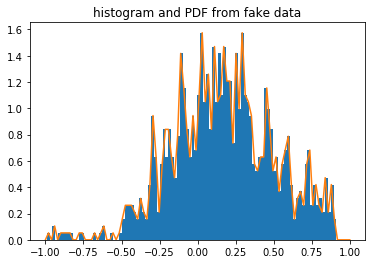

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.linspace(-1.0, 1.0, 100)
plt.title("histogram and PDF from fake data")
plt.hist(sim_data2[0], density=True, bins=100)
plt.plot(X, hist3_dist.pdf(X), label='PDF')
plt.show()

## 4. Empirical data

Now, we'll use empirical rather than simulated data: Tennesse rainfall.

In [104]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

In [105]:
precip = pd.read_table("data/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

FileNotFoundError: [Errno 2] File b'data/nashville_precip.txt' does not exist: b'data/nashville_precip.txt'

In [ ]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

In [ ]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)

This is precipitation for the month of April and its histogram:

In [ ]:
precip.Apr

In [ ]:
april_h = precip.Apr.hist(normed=True, bins=30)

In [ ]:
precip.Apr.values

In [ ]:
wx_hist = np.histogram(precip.Apr.values, bins=100)
wx_hist

In [ ]:
wx_hist[0]

Let's use the histogram from precipitation for the month of April as input. First, we'll do it with our prototype, then with the general class we wrote:

In [ ]:
precip.Apr.values.min()

In [ ]:
precip.Apr.values.max()

In [ ]:
# inputs
h = wx_hist[0]
r = (precip.Apr.values.min(), precip.Apr.values.max())
n = 10000

# we build
x = np.linspace(r[0], r[1], len(h))
x[0], x[len(h)//2], x[len(h)-1]

In [ ]:
my_random_variates = []
for _ in range(n):
    i = roulette_selection(h)
    if i == len(h) - 1: i -= 1
    my_random_variates.append(random.uniform(x[i], x[i+1]))
    
my_not_so_random_histogram = np.histogram(my_random_variates, bins=len(h))

plt.title("my not-so-random histogram")
plt.plot(my_not_so_random_histogram[0], label='generated histogram')
plt.plot(my_not_so_random_histogram[0].max() / h.max() * h, label='original histogram')
plt.show()

</br >
<center>
<img src="https://media3.giphy.com/media/7NOL7wCK1ddCQTiv51/giphy.gif" width=400 />
</center>

Now let's use our class:

In [ ]:
wx_from_hist = GeneralRandom(x = pylab.arange(-1.0, 1.0, .02), p = wx_hist[0], Nrl = 100)
wx_from_hist.self_test()

Let's generate random precipitation values from the month of April that abide by that histogram:

In [ ]:
wx_sim_data = wx_from_hist.random()
wx_sim_data

In [ ]:
wx_sim_data[0]

Let's plot the histogram of these fake precipitation values:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title("histogram from fake wx data")
plt.plot(np.histogram(wx_sim_data[0], bins=100)[0], label='histogram')
plt.show()

Does the histogram from the fake precipitation values look like Tennessee's real April histogram?

In [ ]:
april_h = precip.Apr.hist(normed=True, bins=30)

# Conclusion

Math is by far the best model, since functions give us the *lowest possible model dimensionality reduction*. But when the math is too tough, you can always pick a *program*. The number of SLOC in the program will be much bigger than the number of parameters in your analytic function, but if your model *rocks*, like the one in this notebook, then use it!

That is the principle behind Machine Leanring (ML). Sometimes, the math is too tough for very strange-looking (or lots of) data. So instead of building a model with math functions, we build a model by writing a program that matches the statistics of our input dataset + label. That is what Artificial Neural Networks do (because graphs are a general way of drawing curves in n dimensions) and what deep learning is all about, and we'll see this when you come back fro spring break (after we study linear algebra and graphs).